In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import pandas as pd
import scipy.stats as st
import numpy as np
from src.get_project_data import housing_data, locale_data
pd.options.mode.chained_assignment = None  # default='warn'  # Hide SettingWithCopyWarning

In [2]:
housing_df = housing_data()
locale_df = locale_data()

In [3]:
# Define list of zip codes for Austin area
_AUSTIN_AREA_ZIP_CODES = [78701, 78702, 78703, 78704, 78705, 78721, 78722, 78723, 78731, 78751, 78752, 78756, 78757, 78758, 78759]

# Filter housing_df by Austin area zip codes
housing_df = housing_df[housing_df['zipcode'].isin(_AUSTIN_AREA_ZIP_CODES)]

# Merge with locale_df
df_full = housing_df.merge(locale_df, how='left', on='zipcode')

# Fill missing values with 0
df_full[['pending_listing_count', 'active_listing_count', 'new_listing_count', 'total_listing_count']] = df_full[['pending_listing_count', 'active_listing_count', 'new_listing_count', 'total_listing_count']].fillna(0)

# Print shape and sample of df_full
print(df_full.shape)
df_full.sample(10)



(1215, 41)


,date,zipcode,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,LOCALE
1095,2017-02-01,78731,"austin, tx",710000,NaN,NaN,80,NaN,NaN,54,...,NaN,NaN,116,NaN,NaN,0.4465,NaN,NaN,NaN,11
486,2020-07-01,78703,"austin, tx",1150000,-0.0285,0.2527,107,0.0094,0.0094,62,...,-0.0155,0.0921,144,0.0324,0.0214,0.3505,0.0344,0.0203,1.0,11
238,2021-12-01,78705,"austin, tx",372425,-0.0504,0.1786,23,-0.2105,-0.6457,59,...,-0.1042,0.1738,36,-0.1548,-0.6203,0.6000,0.1263,0.1354,0.0,11
211,2022-01-01,78751,"austin, tx",562000,-0.0004,0.1788,8,-0.2727,-0.5294,28,...,0.1127,0.8322,16,-0.1795,-0.6522,1.0000,0.3636,-0.7059,0.0,11
912,2018-03-01,78759,"austin, tx",480000,-0.0209,-0.1267,53,0.0707,0.0095,37,...,-0.0372,-0.1246,83,-0.0460,-0.0726,0.5849,-0.1525,-0.1294,1.0,11
83,2022-10-01,78705,"austin, tx",364950,-0.0073,-0.0640,45,-0.1089,0.6667,60,...,-0.0962,0.3553,47,-0.1376,0.2368,0.0444,-0.0447,-0.3630,0.0,11
287,2021-08-01,78701,"austin, tx",863425,0.0040,0.0820,53,0.0294,-0.7464,36,...,0.0461,0.2028,82,-0.0465,-0.6419,0.5619,-0.1440,0.4605,0.0,11
109,2022-08-01,78703,"austin, tx",1732500,-0.0348,0.1903,69,0.0615,0.6429,46,...,-0.0239,0.0666,81,0.0125,0.2558,0.2101,-0.0206,-0.3256,0.0,11
59,2022-12-01,78701,"austin, tx",905000,0.0647,0.2832,64,-0.0657,1.4615,66,...,-0.0149,0.0505,72,-0.0649,0.5000,0.1094,-0.0147,-0.7560,0.0,11
665,2019-07-01,78758,"austin, tx",339675,-0.0140,0.1450,31,0.0893,-0.2179,21,...,-0.0029,0.0745,66,0.1379,-0.0704,1.0656,-0.0059,0.2451,0.0,11


In [4]:
austin_df = df_full[df_full['zipcode'].isin(_AUSTIN_AREA_ZIP_CODES)]
by_month_totals = austin_df.groupby("date")\
                         .agg({"pending_listing_count": "sum",
                               "active_listing_count": "sum",
                               "new_listing_count": "sum",
                               "total_listing_count": "sum"})\
                         .rename(columns={"pending_listing_count": "Pending Totals",
                                          "active_listing_count": "Active Listings Totals",
                                          "new_listing_count": "New Listings Totals",
                                          "total_listing_count": "Total Listings"})
by_month_totals.head()

,Pending Totals,Active Listings Totals,New Listings Totals,Total Listings
date,,,,
2016-07-01,528,1126,600,1665
2016-08-01,497,1148,522,1637
2016-09-01,458,1182,520,1632
2016-10-01,447,1199,532,1652
2016-11-01,453,1157,380,1601


In [5]:


# Group by year and month
by_year_month = by_month_totals.groupby(pd.Grouper(freq="M")).sum()

# Calculate the yearly average of pending listings
yearly_avg_pending = by_year_month.groupby(by_year_month.index.year).mean()[["Pending Totals"]]

# Rename column to "Avg Pending Listings per Month"
yearly_avg_pending.rename(columns={"Pending Totals": "Avg Pending Listings per Month"}, inplace=True)

# Add a column for the year
yearly_avg_pending["Year"] = yearly_avg_pending.index

# Set the year as the index
yearly_avg_pending.set_index("Year", inplace=True)

# Print the table
print(yearly_avg_pending)



      Avg Pending Listings per Month
Year                                
2016                      461.166667
2017                      496.416667
2018                      500.416667
2019                          508.75
2020                      584.666667
2021                      570.916667
2022                          273.25
2023                      226.333333


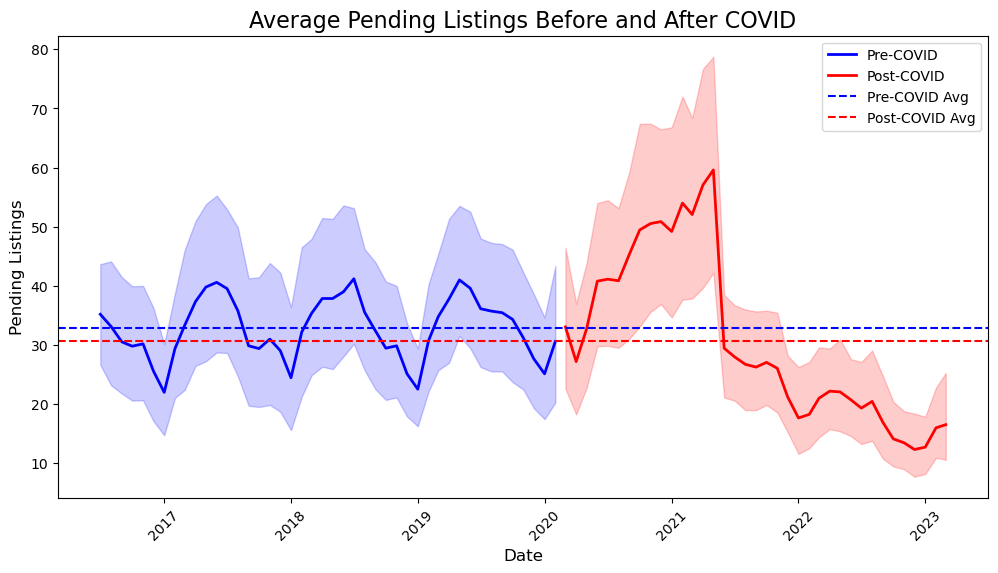

In [12]:


# Calculate pre-COVID and post-COVID averages
df_full['is_covid'] = df_full['date'].apply(lambda x: x >= pd.Timestamp(2020, 3, 1))
pre_covid_avg = df_full.loc[df_full['is_covid'] == False, 'pending_listing_count'].mean()
post_covid_avg = df_full.loc[df_full['is_covid'] == True, 'pending_listing_count'].mean()

# Create pre-COVID and post-COVID data frames
pre_covid_data = df_full.loc[df_full['is_covid'] == False]
post_covid_data = df_full.loc[df_full['is_covid'] == True]

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot pre-COVID data
sns.lineplot(data=pre_covid_data, x='date', y='pending_listing_count', color='blue', label='Pre-COVID', linewidth=2)

# Plot post-COVID data
sns.lineplot(data=post_covid_data, x='date', y='pending_listing_count', color='red', label='Post-COVID', linewidth=2)

# Add horizontal line for pre-COVID average
ax.axhline(pre_covid_avg, ls='--', color='blue', linewidth=1.5, label='Pre-COVID Avg')

# Add horizontal line for post-COVID average
ax.axhline(post_covid_avg, ls='--', color='red', linewidth=1.5, label='Post-COVID Avg')

# Add x-axis and y-axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Pending Listings', fontsize=12)

# Add plot title
ax.set_title('Average Pending Listings Before and After COVID', fontsize=16)

# Set x-axis tick parameters
ax.tick_params(axis='x', labelrotation=45)

# Set legend parameters
ax.legend(fontsize=10)

# Display plot
plt.show()

